In [6]:
KAGGLE_INPUT_PATH=r'C:\Users\Wouter\Documents\Projects\Underwater-image-enhancement\kaggle\input'
KAGGLE_WORKING_PATH=r'C:\Users\Wouter\Documents\Projects\Underwater-image-enhancement\kaggle\working'
KAGGLE_SYMLINK='kaggle'

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'underwater-image-enhancement-benchmark-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4598312%2F7843065%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240408%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240408T134241Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9d22a95dc67225330cf8cd0a043089f68b223e5c5b362272b8bbf517e02f8e417855d679527b79779ebed14004617a77fae1712e6a867c3d1bea4e8fb8c7f636afb0a3a987e23c072ddedfdd83f534c2b0966fdd3e521122f03a18be3fd980b415761a20a9eabe2635fd872996c0368280b4cc91a0b6207637d025dce552c991ad1dd4bc84bd42f2734f370dcf23a330d975834b588387fe4f56d728309694578013a2107298d9aca696a0efa21983371859ae2c42a2bb8e28cfc333acfdd28146da29c382c7022801162663b40af23a65528cab1dbfaada95244b0f24d2b2568036483b71ff796a73aa5d18bec051a0c46d1ba9a54daef9f15080e6f7580f63'



# !umount /kaggle/input/ 2> /dev/null
# shutil.rmtree(r'C:\Users\Wouter\Documents\Projects\Underwater-image-enhancement\kaggle\input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1487726673 bytes downloaded
Downloaded and uncompressed: underwater-image-enhancement-benchmark-dataset
Data source import complete.


# Multi-view underwater image enhancement method via embedded fusion mechanism
Link to paper: https://doi.org/10.1016/j.engappai.2023.105946

Link to data: https://li-chongyi.github.io/proj_benchmark.html


In [1]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np
import pandas as pd
from random import sample
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch import nn
import cv2
from tqdm import tqdm
from torchvision.utils import save_image
from torchvision.io import read_image
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%load_ext tensorboard
%matplotlib inline

## Data Inspection

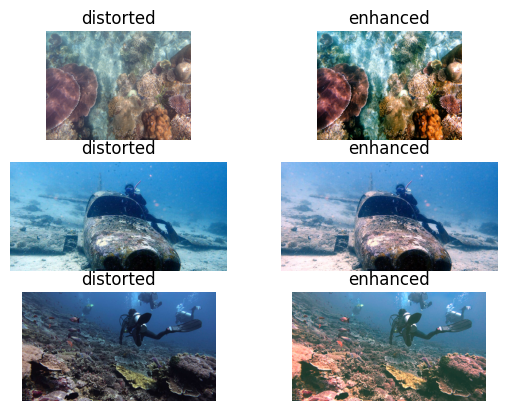

In [7]:
base_input_folder =  KAGGLE_INPUT_PATH + '/underwater-image-enhancement-benchmark-dataset/underwater_images'
base_output_folder = KAGGLE_WORKING_PATH
x_folder = base_input_folder + '/distorted/'
x_folder_clahe = base_output_folder + '/clahe/'
x_folder_wb = base_output_folder + '/wb/'
y_folder = base_input_folder + '/enhanced/'

f, axarr = plt.subplots(3,2)
for i, filename in enumerate(sample(os.listdir(x_folder),3)):
    distorted = mpimg.imread(os.path.join(x_folder, filename))
    enhanced = mpimg.imread(os.path.join(y_folder, filename))

    axarr[i, 0].imshow(distorted)
    axarr[i, 1].imshow(enhanced)
    axarr[i, 0].set_title('distorted')
    axarr[i, 1].set_title('enhanced')
    for ax in axarr[i]:
        ax.set_axis_off()

plt.show()



## Data Pre-Processing

100%|██████████| 890/890 [00:00<00:00, 19753.88it/s]


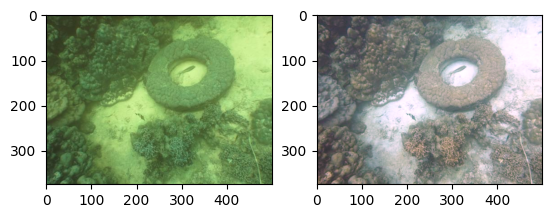

In [8]:
# White Balance (WB)
if not os.path.isdir(x_folder_wb):
    os.mkdir(x_folder_wb)

def white_balance(image, lam=0.2):
    mean_r = np.mean(image[:,:,2])
    mean_g = np.mean(image[:,:,1])
    mean_b = np.mean(image[:,:,0])

    mean = (mean_r + mean_g + mean_b) / 3

    #As suggested by the paper
    mean_increased = 128 + mean*lam

    corrected_r = (mean_increased / mean_r) * image[:,:,2]
    corrected_g = (mean_increased / mean_g) * image[:,:,1]
    corrected_b = (mean_increased / mean_b) * image[:,:,0]

    corrected_image = np.stack([corrected_b, corrected_g, corrected_r], axis=2)
    corrected_image = np.clip(corrected_image, 0, 255)
    corrected_image = corrected_image.astype(np.uint8)

    return corrected_image

for filename in tqdm(os.listdir(x_folder)):
    if os.path.exists(os.path.join(x_folder_wb, filename)):
      continue
    image = cv2.imread(os.path.join(x_folder, filename))
    final_img = white_balance(image)
    plt.imsave(os.path.join(x_folder_wb, filename),final_img)

example_img = '604_img_.png'
_, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.imread(os.path.join(x_folder, example_img)))
axarr[1].imshow(cv2.imread(os.path.join(x_folder_wb, example_img)))
plt.show()

100%|██████████| 890/890 [00:00<00:00, 40311.99it/s]


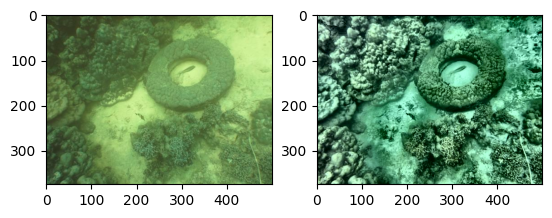

In [9]:
# CLAHE
if not os.path.isdir(x_folder_clahe):
    os.mkdir(x_folder_clahe)

#parameters
clip_limit = 40 # TODO: what should these values be?
tile_grid_size=(8,8)

clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

for filename in tqdm(os.listdir(x_folder)):
    if os.path.exists(os.path.join(x_folder_clahe, filename)):
      continue
    image = cv2.imread(os.path.join(x_folder, filename), cv2.IMREAD_COLOR)
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    image_lab[:,:,0] = clahe.apply(image_lab[:,:,0])
    final_img = cv2.cvtColor(image_lab, cv2.COLOR_Lab2RGB)
    plt.imsave(os.path.join(x_folder_clahe, filename),final_img)


example_img = '604_img_.png'
_, axarr = plt.subplots(1,2)
axarr[0].imshow(cv2.imread(os.path.join(x_folder, example_img)))
axarr[1].imshow(cv2.imread(os.path.join(x_folder_clahe, example_img)))
plt.show()

## Model Setup

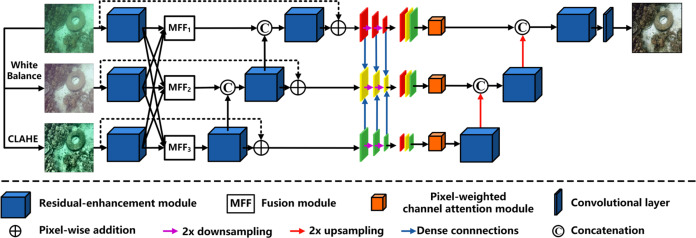

Four main components can be identified:
1. **REM** (Residual-enhancement module)
2. **MFF** (Multi-feature fusion)
3. **Downsampling and dense connections** (colors in image above)
4. **PCAM** (Pixel-weighted channel attention module)

### REM
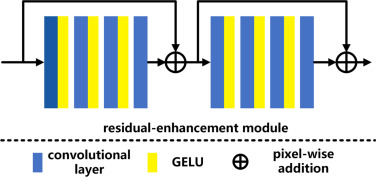


REM stands for Residual-Enhancement Module. For the GELU the PyTorch function is more than sufficient (see [this](https://paperswithcode.com/method/gelu) link).

In [10]:
# Residual enhancement module (REM)
class REM(nn.Module):
    #TODO make channels dynamic
    def __init__(self, input_channels):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding='same')
        self.gelu1 = torch.nn.GELU()
        self.conv2 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding='same')
        self.gelu2 = torch.nn.GELU()
        self.conv3 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding='same')
        self.gelu3 = torch.nn.GELU()
        self.conv4 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding='same')

        self.conv5 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding='same')
        self.gelu4 = torch.nn.GELU()
        self.conv6 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding='same')
        self.gelu5 = torch.nn.GELU()
        self.conv7 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding='same')
        self.gelu6 = torch.nn.GELU()
        self.conv8 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding='same')


    def forward(self, input):
        x1 = self.conv1(input)
        x1 = self.gelu1(x1)
        x1 = self.conv2(x1)
        x1 = self.gelu2(x1)
        x1 = self.conv3(x1)
        x1 = self.gelu3(x1)
        x1 = self.conv4(x1)

        x_between = x1 + input

        x2 = self.conv5(x_between)
        x2 = self.gelu4(x2)
        x2 = self.conv6(x2)
        x2 = self.gelu5(x2)
        x2 = self.conv7(x2)
        x2 = self.gelu6(x2)
        x2 = self.conv8(x2)

        x_end = x2 + x_between

        return x_end


### MFF
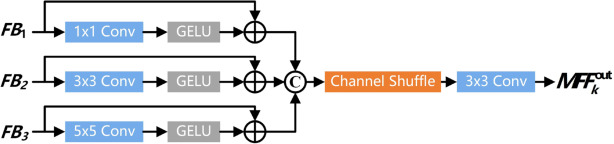

MFF stands for Multi-Feature Fusion. The image above can also be explained in the following formulas:
$$\large \begin{aligned}\\
F_1&=(\sigma(Conv_{1\times1}(FB_1))+FB_1) \\
F_2&=(\sigma(Conv_{3\times3}(FB_2))+FB_2) \\
F_3&=(\sigma(Conv_{5\times5}(FB_3))+FB_3) \\
\\
F_k'&=concat(F_1,F_2,F_3) \\
\\
MFF_k^{out}&=Conv_{3\times3}(\Delta F_k')\\
\end{aligned}$$

Note that $\large \Delta$ represents the channel shuffle. $\large MFF_k^{out}$ denotes the outputs of the $\large k$th MFF.

In [11]:
# Multi-feature fusion (MFF) module
class MFF(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1x1 = torch.nn.Conv2d(3, 3, kernel_size=1, stride=1, padding='same')
        self.conv3x3 = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding='same')
        self.conv5x5 = torch.nn.Conv2d(3, 3, kernel_size=5, stride=1, padding='same')

        self.gelu1 = torch.nn.GELU()
        self.gelu3 = torch.nn.GELU()
        self.gelu5 = torch.nn.GELU()

        # TODO: hoeveel groups?
        groups = 3
        self.shuffle = torch.nn.ChannelShuffle(groups)

        self.conv_final = torch.nn.Conv2d(9, 3, kernel_size=3, stride=1, padding='same')


    def forward(self, FB1, FB2, FB3):
        F1 = self.gelu1(self.conv1x1(FB1)) + FB1
        F2 = self.gelu3(self.conv3x3(FB2)) + FB2
        F3 = self.gelu5(self.conv5x5(FB3)) + FB3

        # print(F1.shape, F2.shape, F3.shape)
        Fk = torch.cat((F1,F2,F3))

        # Shuffle removed because derivative not implemented
        MFFk = self.conv_final(Fk)

        return MFFk



### Downsampling and dense connections (DSDC)

Down-Sampling and Dense Connections (DSDC) performs two down-sampling operations to get shallow features and concatenate features of the same size. It takes three coded features and outputs another three coded features.

In [12]:


class DSDC(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, F1, F2, F3):
        # print("---- DSDC ----")
        # print("F1 shape", F1.shape)
        # print("F2 shape", F2.shape)
        # print("F3 shape", F3.shape)
        F_largest = torch.cat((F1, F2, F3))
        # Calculate padding
        # Padding format is [left, right, top, bottom] for the last two dimensions
        padding_large = [0, 1 if F_largest.size(2) % 2 != 0 else 0,  # Padding for width (right)
                         0, 1 if F_largest.size(1) % 2 != 0 else 0]  # Padding for height (bottom)

        F_largest_padded = torch.nn.functional.pad(F_largest, pad=padding_large, mode='constant', value=0)

        F_middle = F_largest_padded[::,::2,::2]

        padding_medium =    [0, 1 if F_middle.size(2) % 2 != 0 else 0,  # Padding for width (right)
                             0, 1 if F_middle.size(1) % 2 != 0 else 0]  # Padding for height (bottom)

        F_middle_padded = torch.nn.functional.pad(F_middle, pad=padding_medium, mode='constant', value=0)

        F_smallest = F_middle_padded[::,::2,::2]


        # print("F_largest shape", F_largest.shape)
        # print("F_middle shape", F_middle.shape)
        # print("F_smallest shape", F_smallest.shape)

        return F_largest, F_middle, F_smallest



### PCAM

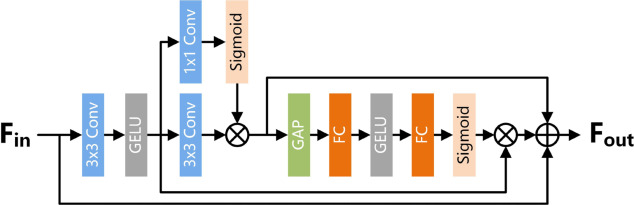

PCAM stands for Pixel-weighted Channel Attention Module. The image above can also be described by the following formulas:

$$\large \begin{aligned}
F_n &= \delta(Conv_{3\times3}(F_{in}) \\
F &= Conv_{3\times3}(F_n) \otimes \sigma(Conv_{1\times1}(F_n)) \\
o_k &= \frac{1}{H\times W} \displaystyle \sum_x^H \sum_y^W F_k(x,y) \\
f_1 &= \delta(W_1 * o) \\
f_2 &= \sigma(W_2 * f_1) \\
F_{out} &= F + F_{in} + F_n \otimes f_2 \\
\end{aligned}$$

Where $\large \delta(\cdot)$ is GELU and $\large \sigma(\cdot)$ is sigmoid activation. $\large \otimes$ denotes the multiplication of the corresponding pixels.

Global average pooling is employed to obtain the attention of each channel and obtain the descriptor $\large o_k$, where $\large k \in [1,N]$ captures the correlation of the channels. $\large f_1$ and $\large f_2$ represent the sets of different weights assigned to each feature map. The results obtained by the squeeze operation $\large o$ on the weights obtained by the fully connected layer are $\large W_1$ and $\large W_2$, where $\large *$ is the convolution calculation. $\large o$ obtained $\large f_1$ after the convolution and the whole connection operation.

In [13]:
# Pixel-weighted channel attention module (PCAM)
class PCAM(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.conv3_1 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding=1)
        self.gelu1 = torch.nn.GELU()
        self.conv1 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=1, stride=1, padding=0)
        self.conv3_2 = torch.nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding=1)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))
        # fc_size = 125*166
        fc_size = 100
        self.fc1 = torch.nn.Linear(input_channels, input_channels)
        self.gelu2 = torch.nn.GELU()
        self.fc2 = torch.nn.Linear(input_channels, input_channels)
        self.sigmoid2 = torch.nn.Sigmoid()


    def forward(self, F_in):
      # print("---- PCAM ----")
      # print(f"F_in Shape: {F_in.shape}")
      F_n = self.gelu1(self.conv3_1(F_in))
#       print(f"F_n Shape: {F_n.shape}")
      F = torch.mul(self.sigmoid1(self.conv1(F_n)), self.conv3_2(F_n))
#       print(f"F Shape: {F.shape}")
      O = self.gap(F).view(9)
#       print(f"O Shape: {O.shape}")
      f1 = self.gelu2(self.fc1(O))
#       print(f"f1 Shape: {f1.shape}")
      f2 = self.sigmoid2(self.fc2(f1))
#       print(f"f2 Shape: {f2.shape}")
      F_out = F + F_in + F_n * f2[:, None, None]
      # print(f"F_out Shape: {F_out.shape}")
      return F_out


### Final network

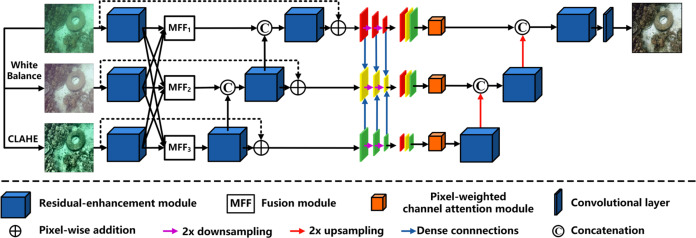

In this section we will combine all the previous modules in the structure explained in the image above.

In [14]:


# Final network
class MFEF(nn.Module):

    def __init__(self):
        super().__init__()

        self.rem1_1 = REM(3)
        self.rem1_2 = REM(3)
        self.rem1_3 = REM(3)

        self.mff1 = MFF()
        self.mff2 = MFF()
        self.mff3 = MFF()

        self.rem2_1 = REM(9)
        self.rem2_2 = REM(6)
        self.rem2_3 = REM(3)

        self.dim_reduce1 = torch.nn.Conv2d(6, 3, kernel_size=3, stride=1, padding='same')
        self.dim_reduce2 = torch.nn.Conv2d(9, 3, kernel_size=3, stride=1, padding='same')

        self.dsdc = DSDC()

        self.pcam1 = PCAM(9)
        self.pcam2 = PCAM(9)
        self.pcam3 = PCAM(9)

        self.upsampling = torch.nn.Upsample(scale_factor=2, mode='nearest')

        self.rem3_1 = REM(27)
        self.rem3_2 = REM(18)
        self.rem3_3 = REM(9)

        self.conv = torch.nn.Conv2d(27, 3, kernel_size=3, stride=1, padding='same')

    def forward(self, input_orig, input_wb, input_clahe):


        rem1_1_res = self.rem1_1(input_orig)
        rem1_2_res = self.rem1_2(input_wb)
        rem1_3_res = self.rem1_3(input_clahe)

        # mff1_res = self.mff1(rem1_1_res, rem1_2_res, rem1_3_res)
        mff2_res = self.mff2(rem1_1_res, rem1_2_res, rem1_3_res)
        mff3_res = self.mff3(rem1_1_res, rem1_2_res, rem1_3_res)

        rem2_3_res = self.rem2_3(mff3_res)
        # print(torch.cat((mff2_res, rem2_3_res), dim=0).shape)
        rem2_2_res = self.rem2_2(torch.cat((mff2_res, rem2_3_res), dim=0))
        rem2_1_res = self.rem2_1(torch.cat((mff3_res, rem2_2_res), dim=0))

        dsdc_1_in = input_orig + self.dim_reduce2(rem2_1_res)
        dsdc_2_in = input_wb + self.dim_reduce1(rem2_2_res)
        dsdc_3_in = input_clahe + rem2_3_res

        dsdc_1_out, dsdc_2_out, dsdc_3_out = self.dsdc(dsdc_1_in, dsdc_2_in, dsdc_3_in)
        # print(dsdc_1_in.shape, dsdc_1_out.shape)
        # print(dsdc_2_in.shape, dsdc_2_out.shape)
        # print(dsdc_3_in.shape, dsdc_3_out.shape)


        pcam1_res = self.pcam1(dsdc_1_out)
        pcam2_res = self.pcam2(dsdc_2_out)
        pcam3_res = self.pcam3(dsdc_3_out)

        # print("---- MFEF ----")

        full_size = pcam1_res.shape
        half_size = pcam2_res.shape
        # print("pcam1", pcam1_res.shape)
        # print("pcam2", pcam2_res.shape)
        # print("pcam3", pcam3_res.shape)


        rem3_3_res = self.rem3_3(pcam3_res)
        rem3_3_res = rem3_3_res
        # print("rem3_3", rem3_3_res.shape)

        rem3_3_res_up = self.upsampling(rem3_3_res.unsqueeze(0)).squeeze()
        # print("rem3_3_up", rem3_3_res_up.shape)
        # if size is not correct, crop off the added padding
        if rem3_3_res_up.shape != full_size:
            rem3_3_res_up = rem3_3_res_up[:, :half_size[1], :half_size[2]]
            # print("rem3_3_up", rem3_3_res_up.shape)

        rem3_2_res = self.rem3_2(torch.cat((pcam2_res, rem3_3_res_up)))
        # print("rem3_2", rem3_2_res.shape)

        rem3_2_res_up = self.upsampling(rem3_2_res.unsqueeze(0)).squeeze()
        # print("rem3_2_up", rem3_2_res_up.shape)
        if rem3_2_res_up.shape != full_size:
            rem3_2_res_up = rem3_2_res_up[:, :full_size[1], :full_size[2]]
            # print("rem3_3_up", rem3_3_res_up.shape)

        rem3_1_res = self.rem3_1(torch.cat((pcam1_res, rem3_2_res_up)))
        # print("rem3_1", rem3_1_res.shape)
        #
        out = self.conv(rem3_1_res)
        # print("out", out.shape)
        return out

## Running Model

In [15]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_names):
        self.input_file_names = [os.path.join(x_folder, file_name) for file_name in file_names]
        self.label_file_names = [os.path.join(y_folder, file_name) for file_name in file_names]
        self.wb_file_names =    [os.path.join(x_folder_wb, file_name) for file_name in file_names]
        self.clahe_file_names = [os.path.join(x_folder_clahe, file_name) for file_name in file_names]

    def __len__(self):
        return len(self.input_file_names)

    def __getitem__(self, idx):
        image_orig = Image.open(self.input_file_names[idx])
        image_wb = Image.open(self.wb_file_names[idx])
        image_clahe = Image.open(self.clahe_file_names[idx])

        inputs = [image_orig, image_wb, image_clahe]

        convert_tensor = transforms.ToTensor()

        inputs = [convert_tensor(x) for x in inputs]

        # remove alpha channel in white balance
        for i in range(len(inputs)):
            x = inputs[i]
            if x.shape[0] == 4:
                inputs[i] = x[:3]

        label = convert_tensor(Image.open(self.label_file_names[idx]))
        if label.shape[0] == 4:
            label = label[:3]

        return inputs, label

In [16]:
## implementation of testing metrics

import cv2
import numpy as np
import scipy.signal
def PCQI(img1, img2):

    window = np.multiply(cv2.getGaussianKernel(11, 1.5), (cv2.getGaussianKernel(11, 1.5)).T)

    L = 256

    # img1 = color.rgb2gray(img1, channel_axis=0)
    # img2 = color.rgb2gray(img2, channel_axis=0)

    window = window / np.sum(np.sum(window))

    img1 = img1.sum(0)
    img2 = img2.sum(0)
    
    mu1 = scipy.signal.correlate2d(img1, window, 'valid')
    mu2 = scipy.signal.correlate2d(img2, window, 'valid')
    mu1_sq = mu1 * mu1

    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2


    sigma1_sq = scipy.signal.correlate2d(img1 * img1, window, 'valid')- mu1_sq
    sigma2_sq = scipy.signal.correlate2d(img2 * img2, window, 'valid') - mu2_sq
    sigma12 = scipy.signal.correlate2d(img1 * img2, window, 'valid') - mu1_mu2

    sigma1_sq[sigma1_sq<0]=0
    sigma2_sq[sigma2_sq<0]=0


    C = 3

    pcqi_map = (4 / np.pi) * np.arctan((sigma12 + C) / (sigma1_sq + C))
    pcqi_map = pcqi_map * ((sigma12 + C) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C))
    pcqi_map = pcqi_map * np.exp(-abs(mu1 - mu2) / L)

    mpcqi = np.mean(pcqi_map)

    return mpcqi, pcqi_map


from skimage.metrics import structural_similarity as compare_ssim
import math
import sys
from skimage import io, color, filters
import os
import math

def rmetrics(a,b):

    #pnsr
    mse = np.mean((a-b)**2)
    psnr = 10*math.log10(1/mse)

    #ssim
    ssim = compare_ssim(a,b,multichannel=True, channel_axis=0, data_range=1)

    return psnr, ssim

def nmetrics(a):
    rgb = a
    lab = color.rgb2lab(a, channel_axis=0)
    gray = color.rgb2gray(a, channel_axis=0)
    # UCIQE
    c1 = 0.4680
    c2 = 0.2745
    c3 = 0.2576
    l = lab[:,:,0]

    #1st term
    chroma = (lab[:,:,1]**2 + lab[:,:,2]**2)**0.5
    uc = np.mean(chroma)
    sc = (np.mean((chroma - uc)**2))**0.5

    #2nd term
    top = int(np.round(0.01*l.shape[0]*l.shape[1]))
    sl = np.sort(l,axis=None)
    isl = sl[::-1]
    conl = np.mean(isl[:top])-np.mean(sl[:top])

    #3rd term
    satur = []
    chroma1 = chroma.flatten()
    l1 = l.flatten()
    for i in range(len(l1)):
        if chroma1[i] == 0: satur.append(0)
        elif l1[i] == 0: satur.append(0)
        else: satur.append(chroma1[i] / l1[i])

    us = np.mean(satur)

    uciqe = c1 * sc + c2 * conl + c3 * us

    # UIQM
    p1 = 0.0282
    p2 = 0.2953
    p3 = 3.5753

    #1st term UICM
    rg = rgb[:,:,0] - rgb[:,:,1]
    yb = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]
    rgl = np.sort(rg,axis=None)
    ybl = np.sort(yb,axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = int(al1 * len(rgl))
    T2 = int(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr)
    s2rg = np.mean((rgl_tr - urg) ** 2)
    uyb = np.mean(ybl_tr)
    s2yb = np.mean((ybl_tr- uyb) ** 2)

    uicm =-0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    #2nd term UISM (k1k2=8x8)
    Rsobel = rgb[:,:,0] * filters.sobel(rgb[:,:,0])
    Gsobel = rgb[:,:,1] * filters.sobel(rgb[:,:,1])
    Bsobel = rgb[:,:,2] * filters.sobel(rgb[:,:,2])

    Rsobel=np.round(Rsobel).astype(np.uint8)
    Gsobel=np.round(Gsobel).astype(np.uint8)
    Bsobel=np.round(Bsobel).astype(np.uint8)

    Reme = eme(Rsobel)
    Geme = eme(Gsobel)
    Beme = eme(Bsobel)

    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    #3rd term UIConM
    uiconm = logamee(gray)

    uiqm = p1 * uicm + p2 * uism + p3 * uiconm
    return uiqm,uciqe

def eme(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)

    eme = 0
    w = 2. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]

            block = ch[xlb:xrb,ylb:yrb]

            blockmin = float(np.min(block))
            blockmax = float(np.max(block))

            # # old version
            # if blockmin == 0.0: eme += 0
            # elif blockmax == 0.0: eme += 0
            # else: eme += w * math.log(blockmax / blockmin)

            # new version
            if blockmin == 0: blockmin+=1
            if blockmax == 0: blockmax+=1
            eme += w * math.log(blockmax / blockmin)
    return eme

def plipsum(i,j,gamma=1026):
    return i + j - i * j / gamma

def plipsub(i,j,k=1026):
    return k * (i - j) / (k - j)

def plipmult(c,j,gamma=1026):
    return gamma - gamma * (1 - j / gamma)**c

def logamee(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)

    s = 0
    w = 1. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]

            block = ch[xlb:xrb,ylb:yrb]
            blockmin = float(np.min(block))
            blockmax = float(np.max(block))

            top = plipsub(blockmax,blockmin)
            bottom = plipsum(blockmax,blockmin)

            m = top/bottom
            if m ==0.:
                s+=0
            else:
                s += (m) * np.log(m)

    return plipmult(w,s)

In [17]:
def train(train_loader, net, optimizer, criterion):
    """
    Trains network for one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        net: The model.
        optimizer: Optimizer.
        criterion: Loss function.
    """

    avg_loss = 0
    correct = 0
    total = 0

    # iterate through batches
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.squeeze().to(device, dtype=torch.float)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs[0].squeeze().to(device, dtype=torch.float), inputs[1].squeeze().to(device, dtype=torch.float), inputs[2].squeeze().to(device, dtype=torch.float))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        avg_loss += loss
        predicted = outputs.data
        total += 1
        correct += (predicted == labels).sum().item()

    return avg_loss/len(train_loader), 100 * correct / total

def test(test_loader, net, criterion):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        net: Neural network model.
        criterion: Loss function.
    """

    avg_loss = 0
    correct = 0
    total = 0

    

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # iterate through batches
        for data in test_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            labels = labels.squeeze().to(device, dtype=torch.float)

            # forward pass
            outputs = net(inputs[0].squeeze().to(device, dtype=torch.float), inputs[1].squeeze().to(device, dtype=torch.float), inputs[2].squeeze().to(device, dtype=torch.float))
            loss = criterion(outputs, labels)
            
            

            # keep track of loss and accuracy
            avg_loss += loss
            predicted = outputs.data
            total += 1
            correct += (predicted == labels).sum().item()

    return avg_loss/len(test_loader), 100 * correct / total

def forward_pass(net, inputs):
    """
    Forward pass of the network.

    Args:
        net: Neural network model.
        inputs: Input tensor.

    Returns:
        Output tensor.
    """
    return net(inputs[0].squeeze().to(device, dtype=torch.float), inputs[1].squeeze().to(device, dtype=torch.float), inputs[2].squeeze().to(device, dtype=torch.float))

# Run one image trough the model

## Problem 1: 4 channels for white balance input
PIL saves image with alpha

Fix: remove the 'alpha' channel such that it has 3 channels:

``image = image[:3]``

## Problem 2: ``'MFF' object has no attribute 'cov1x1'``
Fix: change ``self.cov1x1(FB1)`` to ``self.conv1x1(FB1)``

## Problem 3: invalid arguments ``torch.cat``
Fix: added extra parentheses:
``torch.cat((mff2_res, rem2_3_res))``

## Problem 4:
REM expects 3 channels but after concat this increases to 6. Dit probleem is ook benoemd op mattermost en er is gevraagd of ze al een oplossing hadden. Groepje van Simon heeft een parameter bij hun REM module ``in_channels``.

## problem 5:
PCAM not working correctly. Dimensions don't match.
solutions:
Use (in_channels, in_channels) as input for the linear layers.
Use AdaptiveAvgPool2d(1,1) instead of AvgPool2d(3)
Take view(9) of O
Only take the first dimension of f2

## problem 6:
downscaling by dimensions: the channels are downscaled instead of the height and width of the image.
Downscale the height and width of the image

Problem: dimensions are now different, PCAM has to change

Problem: upscaling still upscales by dimensions
Upscale by height and width

Problem: if image height or width %4 != 0, down and upscaling results in different size
solution: use padding if necessary.

problem: not downscaling by channels anymore -> we have too many channels after concatenation
solution: use convolutional layer at the end to reduce 27 channels to 3.


In [18]:
net = MFEF()

single_sample_org_name = os.listdir(x_folder)[0]
single_sample_wb_name = os.listdir(x_folder_wb)[0]
single_sample_clahe_name = os.listdir(x_folder_clahe)[0]


from torchvision import transforms
from PIL import Image

single_sample_org = Image.open(os.path.join(x_folder, single_sample_org_name))
single_sample_wb = Image.open(os.path.join(x_folder_wb, single_sample_wb_name))
single_sample_clahe = Image.open(os.path.join(x_folder_clahe, single_sample_clahe_name))

inputs = [single_sample_org, single_sample_wb,single_sample_clahe]

convert_tensor = transforms.ToTensor()

inputs = [convert_tensor(x) for x in inputs]

# remove alpha channel in white balance
for i in range(len(inputs)):
    x = inputs[i]
    if x.shape[0] == 4:
        inputs[i] = x[:3]
        
# load model
model_folder = r'C:\Users\Wouter\Documents\Projects\Underwater-image-enhancement\kaggle\working\models'
model_path = os.path.join(model_folder, 'model_10.pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
print(device)
net.load_state_dict(torch.load(model_path, map_location=device))


output = net.forward(inputs[0], inputs[1], inputs[2])



out_path = r'C:\Users\Wouter\Documents\Projects\Underwater-image-enhancement\kaggle\output'
save_image(output, os.path.join(out_path, 'output.png'))


cuda


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [19]:
writer = SummaryWriter()


resume_training = True  # Set to True if resuming, False to train from scratch
start_epoch = 32 if resume_training else 0
model_path_to_resume = os.path.join(model_folder, 'model_{}.pth'.format(start_epoch - 1))
optimizer_path = os.path.join(model_folder, 'optimizer_{}.pth'.format(start_epoch - 1))


if not os.path.isdir(model_folder):
    os.mkdir(model_folder)

# Set the number of epochs to for training
epochs = 100

# Create instance of Network
net = MFEF()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
print(device)

b_size = 1

# Create loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

dataset = ImageDataset(os.listdir(x_folder))

train_set, test_set = torch.utils.data.random_split(dataset, [800, 90])

train_loader = DataLoader(train_set, batch_size=b_size)
test_loader = DataLoader(test_set, batch_size=b_size)

if resume_training and os.path.isfile(model_path_to_resume):
    net.load_state_dict(torch.load(model_path_to_resume, map_location=device))
    print("resuming from model: ", model_path_to_resume)
    # Optionally load optimizer state as well
    # optimizer.load_state_dict(torch.load(optimizer_path))

for epoch in tqdm(range(start_epoch, epochs)):  # loop over the dataset multiple times
    # Train on data
    train_loss, train_acc = train(train_loader,net,optimizer,criterion)

    # Test on data
    test_loss, test_acc = test(test_loader,net,criterion)

    # Write metrics to Tensorboard
    writer.add_scalars("Loss", {'Train': train_loss, 'Test':test_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc,'Test':test_acc} , epoch)
    
    
    path = os.path.join(model_folder, 'model_{}.pth'.format(epoch))
    torch.save(net.cpu().state_dict(), path) # saving model
    torch.save(net.state_dict(), os.path.join(model_folder, 'optimizer_{}.pth'.format(epoch))) # saving optimizer state
    net.cuda() # moving model to GPU for further training


print('Finished Training')
writer.flush()
writer.close()



cuda
resuming from model:  C:\Users\Wouter\Documents\Projects\Underwater-image-enhancement\kaggle\working\models\model_31.pth


  0%|          | 0/68 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [36]:
## output example images
final_net = MFEF()

model_folder = r'C:\Users\Wouter\Documents\Projects\Underwater-image-enhancement\kaggle\working\models'
model_path = os.path.join(model_folder, 'model_14.pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)

net.load_state_dict(torch.load(model_path, map_location=device))


images = range(6,9)
input_images = []
output_images = []
label_images = []

for i in tqdm(images):
    im = test_loader.dataset[i][0]
    im_label = test_loader.dataset[i][1]

    output = forward_pass(net, im)
    
    input_images.append(im[0])
    output_images.append(output)
    label_images.append(im_label)

    out_path = r'C:\Users\Wouter\Documents\Projects\Underwater-image-enhancement\kaggle\output'
    save_image(output, os.path.join(out_path, 'output_{}.png'.format(i)))
    save_image(im[0], os.path.join(out_path, 'input_{}.png'.format(i)))
    save_image(im_label, os.path.join(out_path, 'label_{}.png'.format(i)))
    



100%|██████████| 3/3 [00:10<00:00,  3.42s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


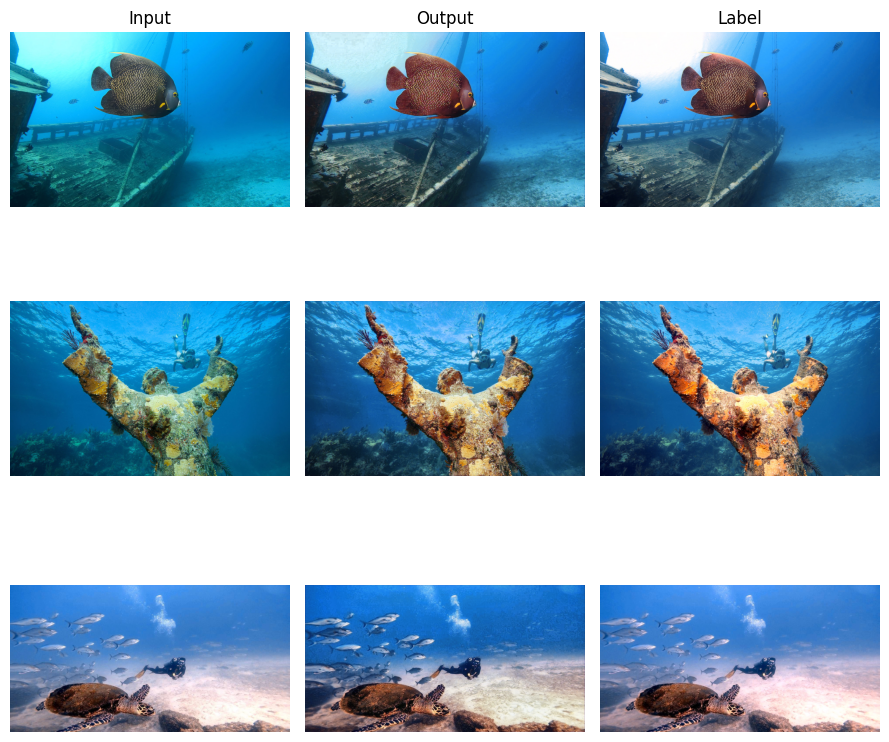

In [37]:
def imshow(img):
    """ Helper function to display a tensor as an image. """
    img.cpu()
    img = img.numpy().transpose(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
    plt.imshow(img)
    plt.axis('off')

fig, axs = plt.subplots(3, 3, figsize=(9, 9))  # Create a 3x3 grid of subplots
titles = ['Input', 'Output', 'Label']


axs[0, 0].set_title(titles[0])  # Set title for each subplot
axs[0, 1].set_title(titles[1])
axs[0, 2].set_title(titles[2])
p = 0
# Display input images
for i in range(3):
    axs[i, 0].imshow(input_images[i+p].cpu().detach().numpy().transpose(1, 2, 0))  
    axs[i, 0].axis('off')  # Hide axes

# Display output images
for i in range(3):
    axs[i, 1].imshow(output_images[i+p].cpu().detach().numpy().transpose(1, 2, 0))
    axs[i, 1].axis('off')

# Display label images
for i in range(3):
    axs[i, 2].imshow(label_images[i+p].cpu().detach().numpy().transpose(1, 2, 0))
    axs[i, 2].axis('off')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  # Display the figure with the images

In [23]:
## metrics

total = 0
total_psnr = 0
total_ssim = 0
total_uiqm = 0
total_uciqe = 0
total_pcqi = 0

print(test_loader)
# iterate through batches
for data in tqdm(test_loader):
    
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    labels = labels.squeeze().to(device, dtype=torch.float)

    # forward pass
    outputs = net(inputs[0].squeeze().to(device, dtype=torch.float), inputs[1].squeeze().to(device, dtype=torch.float), inputs[2].squeeze().to(device, dtype=torch.float))
    out = outputs
    label = labels
    # print(out.shape, label.shape)
    
    out = out.cpu()
    label = label.cpu()
    out = out.detach().numpy()
    label = label.detach().numpy()
    # print(out.shape, label.shape)
    # print(out.shape, label.shape)
    # custom metrics
    # psnr, ssim = rmetrics(out, label)
    # uiqm, uciqe = nmetrics(out)
    pcqi, pcqi_map = PCQI(out, label)

    # total_psnr += psnr
    # total_ssim += ssim
    # total_uiqm += uiqm
    # total_uciqe += uciqe
    total_pcqi += pcqi
    
    total += 1


print("PSNR: ", total_psnr/total)
print("SSIM: ", total_ssim/total)
print("UIQM: ", total_uiqm/total)
print("UCIQE: ", total_uciqe/total)
print("PCQI: ", total_pcqi/total)
print("Total: ", total)


  1%|          | 1/90 [00:08<12:05,  8.15s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 82.00 MiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 25.91 GiB is allocated by PyTorch, and 401.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)